# Mod√©le Global de pr√©diction des nouveuax cas de COVID-19 (Tous les pays)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## Chargement des donn√©es 

In [50]:
df = pd.read_csv("../dataset/clean_covid19_data_v2.csv", parse_dates=["date"])

# Tri par pays et date
df = df.sort_values(["country", "date"])

# afficher les premi√®res lignes du DataFrame
print(df.head())

      iso_code continent      country       date  total_cases  new_cases  \
12879      AFG      Asia  Afghanistan 2020-03-29           91         67   
6424       AFG      Asia  Afghanistan 2020-04-05          274        183   
12880      AFG      Asia  Afghanistan 2020-04-12          521        247   
0          AFG      Asia  Afghanistan 2020-04-19          908        387   
6425       AFG      Asia  Afghanistan 2020-04-26         1330        422   

       total_deaths  new_deaths  total_tests  positive_rate  ...  \
12879             2           2       518446           0.21  ...   
6424              5           3      6814263           0.05  ...   
12880            15          10      1716584           0.18  ...   
0                30          15      8796131           0.19  ...   
6425             43          13      7514673           0.30  ...   

       hospital_beds_per_thousand  extreme_poverty  new_vaccinations_smoothed  \
12879                         0.5            0.334   

## Feature Engineering
## Cr√©ation de nouvelles colonnes pour les caract√©ristiques temporelles

In [ ]:
# Regroupement par pays
grouped = df.groupby("country")

def add_features(group):
    group = group.copy()
    group["new_cases_lag1"] = group["new_cases"].shift(1)
    group["new_cases_lag7"] = group["new_cases"].shift(7)
    group["new_cases_ma7"] = group["new_cases"].rolling(window=7).mean()
    group["growth_rate"] = group["new_cases"] / (group["new_cases_lag1"] + 1e-5)
    # Cr√©ation des colonnes manquantes si elles n'existent pas
    if "vaccinated_rate" not in group.columns:
        group["vaccinated_rate"] = group["people_vaccinated"] / (group["population"] + 1e-5)
    if "boosted_rate" not in group.columns:
        group["boosted_rate"] = group["total_boosters"] / (group["population"] + 1e-5)
    return group

# NOTE : J'ai utilis√© 1e-5 pour √©viter la division par z√©ro dans les taux de vaccination et de rappel.

# Appliquer √† chaque pays
df = grouped.apply(add_features).reset_index(drop=True)

# Suppression des lignes avec valeurs NaN (dues aux shifts)
df = df.dropna()

# Afficher les premi√®res lignes du DataFrame apr√®s ajout des features
print(df.head())

   iso_code continent      country       date  total_cases  new_cases  \
7       AFG      Asia  Afghanistan 2020-05-17         6053       2490   
8       AFG      Asia  Afghanistan 2020-05-24         9866       3813   
9       AFG      Asia  Afghanistan 2020-05-31        14443       4577   
10      AFG      Asia  Afghanistan 2020-06-07        19551       5108   
11      AFG      Asia  Afghanistan 2020-06-14        24102       4551   

    total_deaths  new_deaths  total_tests  positive_rate  ...  \
7            153          48      1922639           0.23  ...   
8            211          58      4476176           0.15  ...   
9            248          37      9649140           0.23  ...   
10           327          79      1383022           0.26  ...   
11           451         124      5729980           0.27  ...   

    total_cases_per_million  new_cases_per_million  total_deaths_per_million  \
7                   149.166                 61.362                     3.770   
8         

C:\Users\wamba\AppData\Local\Temp\ipykernel_6936\3584634287.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = grouped.apply(add_features).reset_index(drop=True)


## Pr√©paration des donn√©es pour l'entra√Ænement

In [52]:
country_columns = [col for col in df.columns if col.startswith("country_")]
features = [
    "new_cases_lag1", "new_cases_lag7", "new_cases_ma7", "growth_rate",
    "reproduction_rate", "positive_rate", "icu_patients", "hosp_patients",
    "stringency_index", "vaccinated_rate", "boosted_rate"
]
target = "new_cases"

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

## Entra√Ænement du mod√®le

In [53]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

## √âvaluation du mod√®le global

In [56]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R¬≤ : {r2:.2f}")

MAE : 6840.29
RMSE : 88702.77
R¬≤ : 0.83


## Courbe r√©elle vs pr√©dite (exemple sur un pays)

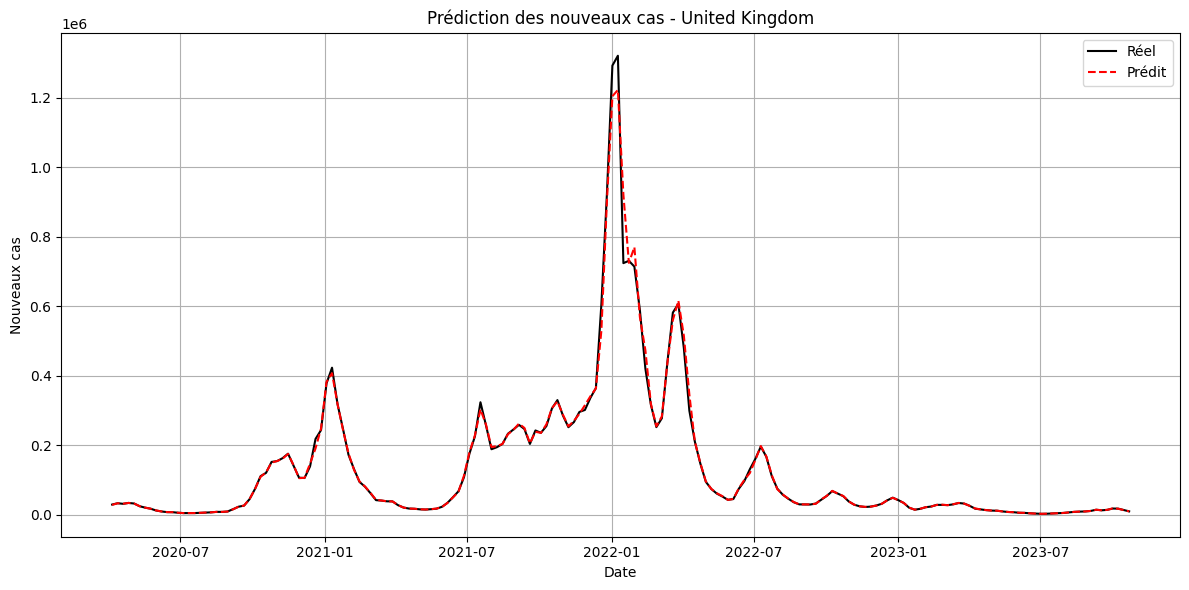

In [71]:
example_country = "United Kingdom"
df_test = df.loc[X_test.index].copy()
df_test["y_pred"] = y_pred

df_test_country = df_test[df_test["country"] == example_country]

plt.figure(figsize=(12, 6))
plt.plot(df_test_country["date"], df_test_country["new_cases"], label="R√©el", color='black')
plt.plot(df_test_country["date"], df_test_country["y_pred"], label="Pr√©dit", color='red', linestyle='--')
plt.title(f"Pr√©diction des nouveaux cas - {example_country}")
plt.xlabel("Date")
plt.ylabel("Nouveaux cas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

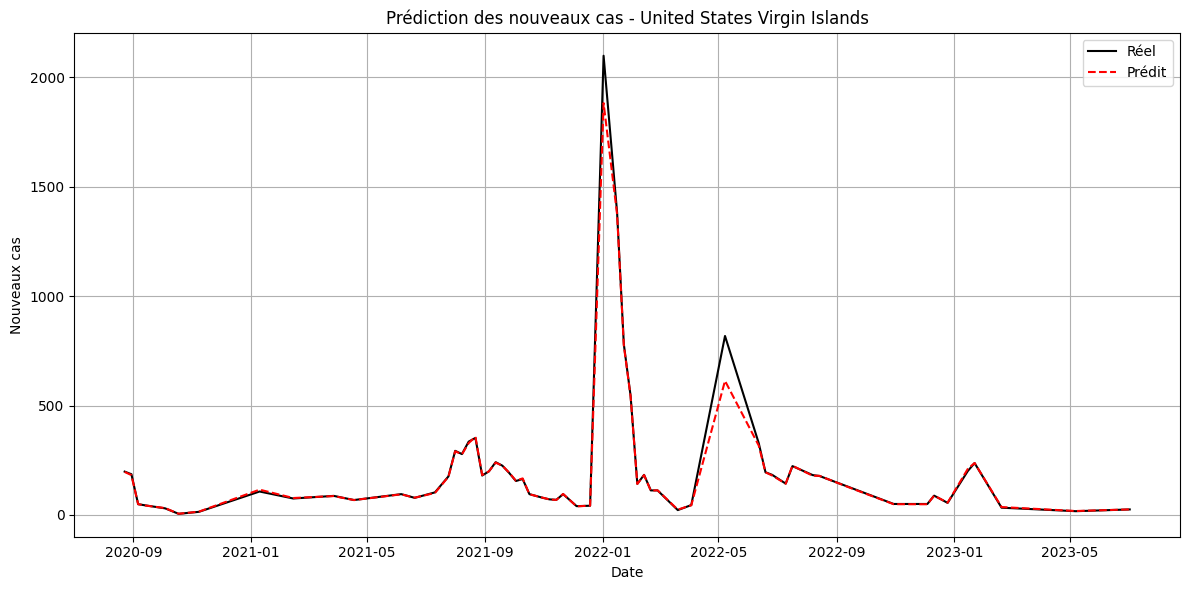

In [69]:
example_country = "United States Virgin Islands"
df_test = df.loc[X_test.index].copy()
df_test["y_pred"] = y_pred

df_test_country = df_test[df_test["country"] == example_country]

plt.figure(figsize=(12, 6))
plt.plot(df_test_country["date"], df_test_country["new_cases"], label="R√©el", color='black')
plt.plot(df_test_country["date"], df_test_country["y_pred"], label="Pr√©dit", color='red', linestyle='--')
plt.title(f"Pr√©diction des nouveaux cas - {example_country}")
plt.xlabel("Date")
plt.ylabel("Nouveaux cas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

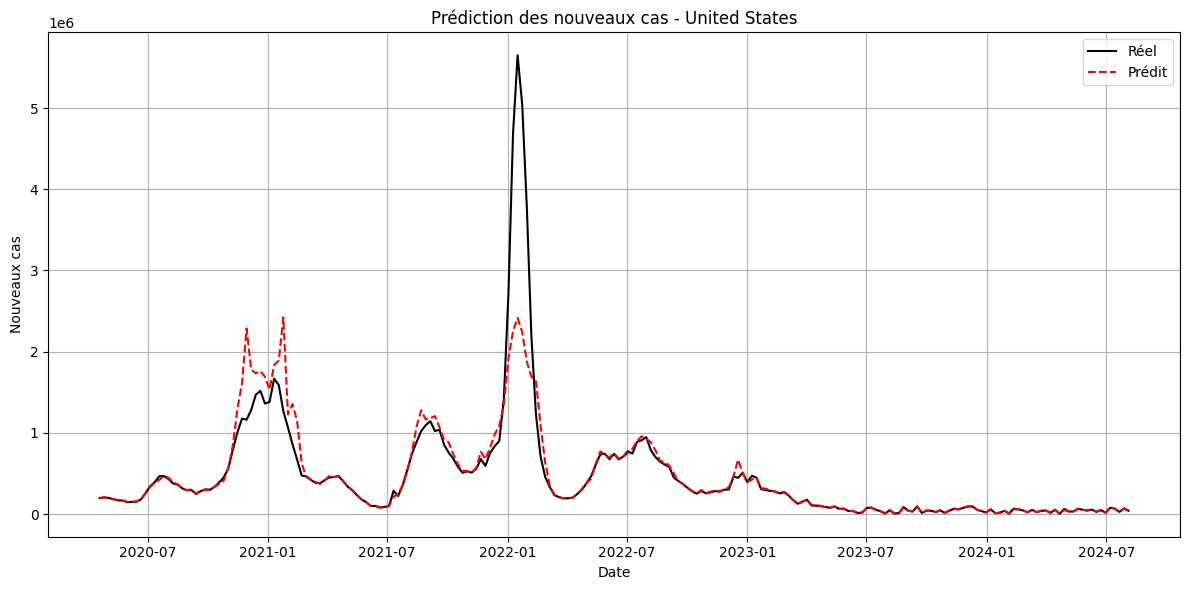

In [70]:
example_country = "United States"
df_test = df.loc[X_test.index].copy()
df_test["y_pred"] = y_pred

df_test_country = df_test[df_test["country"] == example_country]

plt.figure(figsize=(12, 6))
plt.plot(df_test_country["date"], df_test_country["new_cases"], label="R√©el", color='black')
plt.plot(df_test_country["date"], df_test_country["y_pred"], label="Pr√©dit", color='red', linestyle='--')
plt.title(f"Pr√©diction des nouveaux cas - {example_country}")
plt.xlabel("Date")
plt.ylabel("Nouveaux cas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## √âvaluation du Mod√®le ‚Äì Random Forest Global

Ce mod√®le global a pour but de **pr√©dire le nombre de nouveaux cas COVID-19 pour tous les pays**, √† partir de variables √©pid√©miques et politiques historiques, sans tenir compte explicitement du pays (pas de feature `country`).

---

### R√©sultats globaux (test set)

| M√©trique                           | Valeur       |
|-----------------------------------|--------------|
| MAE (Mean Absolute Error)         | 6‚ÄØ840.29     |
| RMSE (Root Mean Squared Error)    | 88‚ÄØ702.77    |
| R¬≤ (Coefficient de d√©termination) | 0.83         |

---

### Interpr√©tation

- **MAE ‚âà 6‚ÄØ840** : en moyenne, le mod√®le se trompe de ~6‚ÄØ840 cas par jour pour un pays donn√©.
- **RMSE ‚âà 88‚ÄØ703** : les grosses erreurs sont fortement p√©nalis√©es ; cela refl√®te les pics violents mal capt√©s.
- **R¬≤ = 0.83** : le mod√®le explique **83‚ÄØ% de la variance globale** des nouveaux cas.

---

### üîé Analyse par courbes

- Pour certains pays comme **United Kingdom**, **United States Virgin Islands** ou **United States**, le mod√®le suit bien la tendance globale.
- Cependant, **lors de pics √©pid√©miques violents**, le mod√®le tend √† :
  - sous-estimer l‚Äôampleur r√©elle,
  - lisser la variation c'est-√†-dire qu'il ne capture pas les pics aigus,
  - r√©agir avec un l√©ger **retard temporel**.

Ces effets sont visibles sur les courbes r√©elles vs pr√©dites.

---

### Limites observ√©es

- Les **ruptures brutales**, caus√©es par des facteurs exog√®nes (variants, changements politiques, etc.) sont difficilement capturables sans **donn√©es contextuelles suppl√©mentaires**.
- Le mod√®le **n‚Äô√©tant pas s√©quentiel**, il ne capture pas toujours les transitions rapides ou √©v√©nements ponctuels.

---

###  Pistes d‚Äôam√©lioration possibles

- Enrichir le mod√®le avec des **donn√©es externes** : mobilit√©, m√©t√©o, restrictions sanitaires d√©taill√©es.
- Tester des mod√®les **s√©quentiels** comme les LSTM (RNN).
- Ajouter un module de **d√©tection de pics** ou d‚Äôanomalies.


In [77]:
# Sauvegarde
import joblib
joblib.dump(model, "../model/rf_model_global.joblib")

['../model/rf_model_global.joblib']